In [59]:
import torch
import tqdm
import logger
import numpy as np
import torch.nn as nn
import pickle
import metrics
from skimage import io
from skimage import transform
# from model import FusionNet, DilationCNN, UNet
# from dataset import NucleiDataset, HPADataset, NeuroDataset, HPASingleDataset,get_augmenter
from torch.utils.data import DataLoader
from loss import dice_loss
import imageio


import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import torchvision
import torchvision.models as tormodel
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import glob
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

def mkdir_if_missing(save_dir):
    if os.path.exists(save_dir):
        return 1
    else:
        os.makedirs(save_dir)
        return 0

# Dataloader

In [60]:
import torch.utils.data as data
from PIL import Image
import os

class GetLoader(data.Dataset):
    def __init__(self, data_root, img_folder, lab_folder, transform=None):
        self.img_root = os.path.join(data_root,img_folder)
        self.mask_root = os.path.join(data_root,lab_folder)
        self.transform = transform
        
        data_list = os.listdir(self.img_root)
        self.n_data = len(data_list)

        self.img_paths = []
        self.lab_paths = []

        for data in data_list:
            self.img_paths.append(os.path.join(self.img_root,data))
            self.lab_paths.append(os.path.join(self.mask_root,data))

    def __getitem__(self, item):
        img_pth, lab_pth = self.img_paths[item], self.lab_paths[item]
        imgs = Image.open(img_pth).convert('RGB')
        labels = np.asarray(imageio.imread(lab_pth))

        if self.transform is not None:
            imgs = self.transform(imgs)
#             labels = self.transform(labels)
        return imgs, labels

    def __len__(self):
        return self.n_data


In [61]:
DATA_DIR = '/home/zhangj41/HW/group_proj/Organ_nuclei'
TRAIN_IMG = 'image_train'
TEST_IMG = 'image_test'
TRAIN_MASK = 'mask_train'
TEST_MASK = 'mask_test'

img_transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
])

'''---train loader---'''
DATASET_TRAIN = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TRAIN_IMG, 
    lab_folder=TRAIN_MASK, 
    transform=img_transform_train
)
DATALOADER_TRAIN = torch.utils.data.DataLoader(
    dataset=DATASET_TRAIN,
    batch_size=50,
    shuffle=True)

'''---test loader---'''
DATASET_TEST = GetLoader(
    data_root=DATA_DIR, 
    img_folder=TEST_IMG, 
    lab_folder=TEST_MASK, 
    transform=img_transform_train
)
DATALOADER_TEST = torch.utils.data.DataLoader(
    dataset=DATASET_TEST,
    batch_size=100,
    shuffle=False)

28


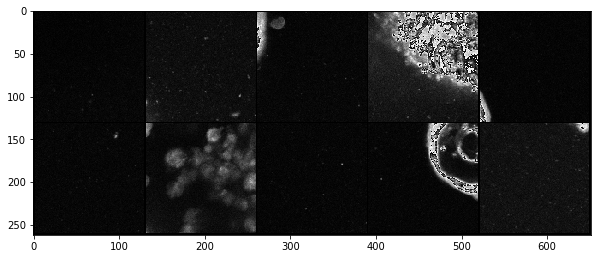

In [62]:
print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
batch_datas, batch_labels = next(iter(DATALOADER_TRAIN)) 
# print(batch_labels)
img = make_grid(batch_datas[0:10], nrow=5, padding=2)

npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [63]:
# batch_labels_ = batch_labels.unsqueeze(1)
# print(batch_labels_.size())
# img = make_grid(batch_labels_[0:10], nrow=5, padding=2)
# npimg = img.numpy()
# print(npimg.shape)
# plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray', interpolation='nearest')

In [64]:
batch_label = batch_labels[5]
batch_label.size()

torch.Size([128, 128])

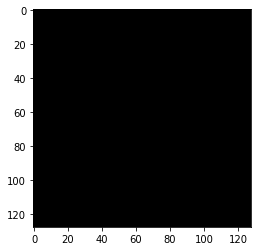

In [65]:
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

# Models

In [66]:
import torch.nn as nn 
import unet_layers as layers


class UNet(nn.Module):
    def __init__(self, num_kernel, kernel_size, dim, target_dim):
        super(UNet, self).__init__()
        self.num_kernel = num_kernel
        self.kernel_size = kernel_size
        self.dim = dim
        self.target_dim = target_dim

        # encode
        self.encode_1 = layers.DownSampling(self.dim, num_kernel, kernel_size)
        self.encode_2 = layers.DownSampling(num_kernel, num_kernel*2, kernel_size)
        self.encode_3 = layers.DownSampling(num_kernel*2, num_kernel*4, kernel_size)
        self.encode_4 = layers.DownSampling(num_kernel*4, num_kernel*8, kernel_size)

        # bridge
        self.bridge = nn.Conv2d(num_kernel*8, num_kernel*16, kernel_size, padding=1, stride=1)

        # decode
        self.decode_4 = layers.UpSampling(num_kernel*16, num_kernel*8, kernel_size)
        self.decode_3 = layers.UpSampling(num_kernel*8, num_kernel*4, kernel_size)
        self.decode_2 = layers.UpSampling(num_kernel*4, num_kernel*2, kernel_size)
        self.decode_1 = layers.UpSampling(num_kernel*2, num_kernel, kernel_size)

        self.segment = nn.Conv2d(num_kernel, self.target_dim, 1, padding=0, stride=1)
        self.activate = nn.Sigmoid()


    def forward(self, x):
        x, skip_1 = self.encode_1(x)
        x, skip_2 = self.encode_2(x)
        x, skip_3 = self.encode_3(x)
        x, skip_4 = self.encode_4(x)

        x = self.bridge(x)

        x = self.decode_4(x, skip_4)
        x = self.decode_3(x, skip_3)
        x = self.decode_2(x, skip_2)
        x = self.decode_1(x, skip_1)

        x = self.segment(x)
        pred = self.activate(x)
        return pred

In [67]:
### debug
# batch_datas, batch_labels = next(iter(dataloader_train)) 
# batch_labels.unsqueeze_(1)
# batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()
# unet = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
# unet.cuda()


In [68]:
# loss_function = dice_loss
# pred = unet(batch_datas)
# print(batch_datas.size(), pred.size(), batch_labels.size())
# loss_function(pred, batch_labels)

In [69]:
# print(torch.min(pred),torch.max(pred))
# print(torch.min(batch_labels),torch.max(batch_labels))

# Utils

## Average meter

In [70]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Cell segmentation

In [71]:
class CellSeg:
    def __init__(self, unet):
        self.unet = unet
        self.unet.cuda()
        self.optimizer = torch.optim.SGD(self.unet.parameters(),
                                         lr=0.01, momentum=0.9, weight_decay=1e-3)
    
    def scheduler(self, epoch, lr0=1e-2):
        lr = lr0
        if epoch >= 80:
            lr = lr0 * 0.1
        if epoch >= 160:
            lr = lr0 * 0.1

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

            
    def train_batch(self,
                    data_loader,
                    epoch):
        '''--- 1. setup network ---'''
        loss_function = dice_loss
#         total_loss = AverageMeter()
#         total_iou = AverageMeter()
#         total_precision = AverageMeter()
        
        # set train state
        self.unet.train()
        len_dataloader = len(data_loader)
        data_iter = iter(data_loader)

        '''--- 2. train network ---'''
        iters=0
        while iters<len_dataloader-1:
            iters+=1
            input_img, class_label = next(data_iter)
            class_label.unsqueeze_(1)
            input_img, class_label = input_img.cuda(), class_label.cuda()
            batch_size = len(class_label)
            '''forward, compute student ce loss'''
            pred_mask = self.unet(input_img)
            loss = loss_function(pred_mask, class_label)
            
            predictions = pred_mask.clone().squeeze().detach().cpu().numpy()
            gt = class_label.clone().squeeze().detach().cpu().numpy()
            ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
            iou_val = np.mean(ious)
            '''backward teacher generate guided-BP map, detach'''
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if iters%1 == 0:
                print('epoch: {}, [iter {} / all {}], loss:{}, iou:{}'\
                      .format(epoch, iters, len_dataloader, 
                              loss.cpu().data.numpy(),
                              iou_val))
        return loss, iou_val
    
    
    def eval_epoch(self, dataloader):
        cudnn.benchmark = True
        loss_function = dice_loss
        '''---evaluation mode---'''
        self.unet.eval()
        len_dataloader = len(dataloader)
        data_test_iter = iter(dataloader)

        i = 0
        n_total = 0
        n_correct = 0
        total_iou = 0
        total_loss = 0
        total_precision = 0
        counter = 0
#         total_iou = []
        with torch.no_grad():
            while i<len_dataloader:
                # test model using target data
                input_img, class_label = next(data_test_iter)
                class_label.unsqueeze_(1)
                input_img, class_label = input_img.cuda(), class_label.cuda()
                batch_size = len(class_label)

                pred_mask = self.unet(input_img)
                dice_loss_ = loss_function(pred_mask, class_label)
                dice_loss_ = dice_loss_.clone().squeeze().cpu().numpy()
                predictions = pred_mask.clone().squeeze().cpu().numpy()
                gt = class_label.clone().squeeze().cpu().numpy()
                ious = [metrics.get_ious(p, g, 0.5) for p,g in zip(predictions, gt)]
                prec = [metrics.compute_precision(p, g, 0.5) for p,g in zip(predictions, gt)]
#                 total_iou.append(np.mean(ious))
                total_loss += np.sum(dice_loss_)
                total_iou += np.sum(ious)
                total_precision += np.sum(prec)
                counter += batch_size
                i += 1
        iou_avg = total_iou/counter #np.mean(total_iou)
        precision_avg = total_precision/counter
        dice_coeff_avg = 1-total_loss/counter
        print('Normal IOU of the dataset: %f' %(iou_avg))
        print('Normal PREC of the dataset: %f' %(precision_avg))
        print('Normal DICE SCORE of the dataset: %f' %(dice_coeff_avg))
        return iou_avg, precision_avg, dice_coeff_avg
        
        
    def Net_train(self,
                  dl_train,dl_val,
                  n_epochs,
                  save_dir):
        loss_ = []
        iou_val_ = []
        acc_ = []
        for epoch in np.arange(n_epochs):
            # training
            self.scheduler(epoch=epoch)
            loss, iou_val = self.train_batch(data_loader=dl_train,
                                                 epoch=epoch)
            loss_.append(loss)
            iou_val_.append(iou_val)
            # save model
            if epoch>=180:
                file_name = 'unet_epoch'+str(epoch)+'.pth'
                torch.save(self.unet.state_dict(), os.path.join(save_dir,file_name))
            # evaluation
            print('================================================================')
            acc = self.eval_epoch(dataloader=dl_val)
            acc_.append(acc)
            print('================================================================')
        return loss_, iou_val_, acc_

# Main

In [28]:
MODEL_SAVE_PATH = '/home/zhangj41/HW/group_proj/Organ_nuclei_models'
mkdir_if_missing(MODEL_SAVE_PATH)

solver = CellSeg(unet=UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1))
loss_, iou_val_, acc_ = solver.Net_train(dl_train=DATALOADER_TRAIN,
                                         dl_val=DATALOADER_TEST,
                                         n_epochs=200,
                                         save_dir=MODEL_SAVE_PATH)

epoch: 0, [iter 1 / all 28], loss:0.9055749773979187, iou:0.008493754081428051
epoch: 0, [iter 2 / all 28], loss:0.8872815370559692, iou:0.018137425184249878
epoch: 0, [iter 3 / all 28], loss:0.8641418814659119, iou:0.03660520911216736
epoch: 0, [iter 4 / all 28], loss:0.8202260732650757, iou:0.06625284254550934
epoch: 0, [iter 5 / all 28], loss:0.7986273169517517, iou:0.07686258107423782
epoch: 0, [iter 6 / all 28], loss:0.7573583126068115, iou:0.09884735196828842
epoch: 0, [iter 7 / all 28], loss:0.757836103439331, iou:0.10166702378541231
epoch: 0, [iter 8 / all 28], loss:0.7970950603485107, iou:0.08484966301824898
epoch: 0, [iter 9 / all 28], loss:0.7326534986495972, iou:0.1075984537601471
epoch: 0, [iter 10 / all 28], loss:0.7332870960235596, iou:0.09911002490669489
epoch: 0, [iter 11 / all 28], loss:0.7859408259391785, iou:0.06846520202234388
epoch: 0, [iter 12 / all 28], loss:0.7026004791259766, iou:0.1296798342745751
epoch: 0, [iter 13 / all 28], loss:0.7865716218948364, iou:0.0

epoch: 3, [iter 20 / all 28], loss:0.7151540517807007, iou:0.11024752818048
epoch: 3, [iter 21 / all 28], loss:0.6991404891014099, iou:0.10691654436290264
epoch: 3, [iter 22 / all 28], loss:0.657142162322998, iou:0.11443911188747734
epoch: 3, [iter 23 / all 28], loss:0.6924588680267334, iou:0.09485988814383745
epoch: 3, [iter 24 / all 28], loss:0.6917586326599121, iou:0.09889290896244347
epoch: 3, [iter 25 / all 28], loss:0.6822975873947144, iou:0.097098975405097
epoch: 3, [iter 26 / all 28], loss:0.6538388729095459, iou:0.14459416396915914
epoch: 3, [iter 27 / all 28], loss:0.7406619191169739, iou:0.0952041675359942
Normal accuracy of the dataset: 0.115761
epoch: 4, [iter 1 / all 28], loss:0.6988387107849121, iou:0.10709593206644058
epoch: 4, [iter 2 / all 28], loss:0.6818145513534546, iou:0.09973043382167816
epoch: 4, [iter 3 / all 28], loss:0.6998435854911804, iou:0.10976120291277766
epoch: 4, [iter 4 / all 28], loss:0.660119891166687, iou:0.14220186475664376
epoch: 4, [iter 5 / all

epoch: 7, [iter 8 / all 28], loss:0.4619254469871521, iou:0.17373378887772561
epoch: 7, [iter 9 / all 28], loss:0.4511653184890747, iou:0.24028407026082277
epoch: 7, [iter 10 / all 28], loss:0.45997339487075806, iou:0.17438201248645782
epoch: 7, [iter 11 / all 28], loss:0.43306440114974976, iou:0.16970922607928515
epoch: 7, [iter 12 / all 28], loss:0.4229479432106018, iou:0.27499371726065874
epoch: 7, [iter 13 / all 28], loss:0.47214871644973755, iou:0.15566265570232646
epoch: 7, [iter 14 / all 28], loss:0.4520546793937683, iou:0.16572971642017365
epoch: 7, [iter 15 / all 28], loss:0.46131008863449097, iou:0.19753246776759625
epoch: 7, [iter 16 / all 28], loss:0.4581516981124878, iou:0.17110386930406093
epoch: 7, [iter 17 / all 28], loss:0.47490477561950684, iou:0.2021793808368966
epoch: 7, [iter 18 / all 28], loss:0.4211575984954834, iou:0.19240325942635536
epoch: 7, [iter 19 / all 28], loss:0.39678341150283813, iou:0.23016921401023865
epoch: 7, [iter 20 / all 28], loss:0.456802189350

epoch: 10, [iter 26 / all 28], loss:0.3149726390838623, iou:0.24980354987084866
epoch: 10, [iter 27 / all 28], loss:0.3572953939437866, iou:0.2609319420158863
Normal accuracy of the dataset: 0.257635
epoch: 11, [iter 1 / all 28], loss:0.3573817014694214, iou:0.22098299920558928
epoch: 11, [iter 2 / all 28], loss:0.2950021028518677, iou:0.2658646510541439
epoch: 11, [iter 3 / all 28], loss:0.32286715507507324, iou:0.24783359948545694
epoch: 11, [iter 4 / all 28], loss:0.2996746301651001, iou:0.33458169251680375
epoch: 11, [iter 5 / all 28], loss:0.3002054691314697, iou:0.2646142552420497
epoch: 11, [iter 6 / all 28], loss:0.29323649406433105, iou:0.28788277864456174
epoch: 11, [iter 7 / all 28], loss:0.30878353118896484, iou:0.26645068570971486
epoch: 11, [iter 8 / all 28], loss:0.28790295124053955, iou:0.3297601819038391
epoch: 11, [iter 9 / all 28], loss:0.276897668838501, iou:0.31144208580255506
epoch: 11, [iter 10 / all 28], loss:0.28920066356658936, iou:0.3002217245846987
epoch: 11

epoch: 14, [iter 14 / all 28], loss:0.23696887493133545, iou:0.32981445014476773
epoch: 14, [iter 15 / all 28], loss:0.24037617444992065, iou:0.35359311938285826
epoch: 14, [iter 16 / all 28], loss:0.23427832126617432, iou:0.36557167522609235
epoch: 14, [iter 17 / all 28], loss:0.25467443466186523, iou:0.27385805249214173
epoch: 14, [iter 18 / all 28], loss:0.2286255955696106, iou:0.29997146904468536
epoch: 14, [iter 19 / all 28], loss:0.22758466005325317, iou:0.3416202110052109
epoch: 14, [iter 20 / all 28], loss:0.2244543433189392, iou:0.3576219207048416
epoch: 14, [iter 21 / all 28], loss:0.23352450132369995, iou:0.33503617182374
epoch: 14, [iter 22 / all 28], loss:0.2156059741973877, iou:0.28692274376749993
epoch: 14, [iter 23 / all 28], loss:0.22878795862197876, iou:0.3298513787984848
epoch: 14, [iter 24 / all 28], loss:0.21378779411315918, iou:0.41328095853328706
epoch: 14, [iter 25 / all 28], loss:0.2555586099624634, iou:0.2962491211295128
epoch: 14, [iter 26 / all 28], loss:0.2

epoch: 18, [iter 2 / all 28], loss:0.16932523250579834, iou:0.4328183577954769
epoch: 18, [iter 3 / all 28], loss:0.14047837257385254, iou:0.3782505589723587
epoch: 18, [iter 4 / all 28], loss:0.15733098983764648, iou:0.42406506299972535
epoch: 18, [iter 5 / all 28], loss:0.1544293761253357, iou:0.37136866271495816
epoch: 18, [iter 6 / all 28], loss:0.18633949756622314, iou:0.3513576745986938
epoch: 18, [iter 7 / all 28], loss:0.1553075909614563, iou:0.3973386359214783
epoch: 18, [iter 8 / all 28], loss:0.16126924753189087, iou:0.36142919421195985
epoch: 18, [iter 9 / all 28], loss:0.16269099712371826, iou:0.3920626080036163
epoch: 18, [iter 10 / all 28], loss:0.16456741094589233, iou:0.34166191816329955
epoch: 18, [iter 11 / all 28], loss:0.15972912311553955, iou:0.46231540337204935
epoch: 18, [iter 12 / all 28], loss:0.1768101453781128, iou:0.41740347564220426
epoch: 18, [iter 13 / all 28], loss:0.160353422164917, iou:0.3644116324186325
epoch: 18, [iter 14 / all 28], loss:0.145373761

epoch: 21, [iter 18 / all 28], loss:0.14031744003295898, iou:0.5028799045085907
epoch: 21, [iter 19 / all 28], loss:0.11784482002258301, iou:0.4907353925704956
epoch: 21, [iter 20 / all 28], loss:0.1345546841621399, iou:0.3850613686442375
epoch: 21, [iter 21 / all 28], loss:0.15987390279769897, iou:0.2984862697124481
epoch: 21, [iter 22 / all 28], loss:0.13126707077026367, iou:0.4219862204790115
epoch: 21, [iter 23 / all 28], loss:0.1400431990623474, iou:0.46457290410995483
epoch: 21, [iter 24 / all 28], loss:0.13784879446029663, iou:0.5151320022344589
epoch: 21, [iter 25 / all 28], loss:0.1401110291481018, iou:0.3364215315878391
epoch: 21, [iter 26 / all 28], loss:0.13332509994506836, iou:0.42299188792705533
epoch: 21, [iter 27 / all 28], loss:0.13664907217025757, iou:0.3813741546869278
Normal accuracy of the dataset: 0.244973
epoch: 22, [iter 1 / all 28], loss:0.12922728061676025, iou:0.5561233079433441
epoch: 22, [iter 2 / all 28], loss:0.13398486375808716, iou:0.4497681361436844
ep

epoch: 25, [iter 6 / all 28], loss:0.09918195009231567, iou:0.4135353446006775
epoch: 25, [iter 7 / all 28], loss:0.09898239374160767, iou:0.5045125198364258
epoch: 25, [iter 8 / all 28], loss:0.09557551145553589, iou:0.3895985889434814
epoch: 25, [iter 9 / all 28], loss:0.08993035554885864, iou:0.5167779111862183
epoch: 25, [iter 10 / all 28], loss:0.09498924016952515, iou:0.48949717700481415
epoch: 25, [iter 11 / all 28], loss:0.09851831197738647, iou:0.4109292739629746
epoch: 25, [iter 12 / all 28], loss:0.09869420528411865, iou:0.4731037974357605
epoch: 25, [iter 13 / all 28], loss:0.11205852031707764, iou:0.40015474557876585
epoch: 25, [iter 14 / all 28], loss:0.09641945362091064, iou:0.4734960597753525
epoch: 25, [iter 15 / all 28], loss:0.09416371583938599, iou:0.502669347524643
epoch: 25, [iter 16 / all 28], loss:0.10409814119338989, iou:0.4592848086357117
epoch: 25, [iter 17 / all 28], loss:0.10934233665466309, iou:0.5162784856557846
epoch: 25, [iter 18 / all 28], loss:0.11511

epoch: 28, [iter 22 / all 28], loss:0.09049838781356812, iou:0.482384170293808
epoch: 28, [iter 23 / all 28], loss:0.08898717164993286, iou:0.457666882276535
epoch: 28, [iter 24 / all 28], loss:0.090628981590271, iou:0.4597862005233765
epoch: 28, [iter 25 / all 28], loss:0.08923900127410889, iou:0.3653985953330994
epoch: 28, [iter 26 / all 28], loss:0.08397024869918823, iou:0.5170688170194626
epoch: 28, [iter 27 / all 28], loss:0.08358210325241089, iou:0.4823711371421814
Normal accuracy of the dataset: 0.259669
epoch: 29, [iter 1 / all 28], loss:0.07725352048873901, iou:0.4909887194633484
epoch: 29, [iter 2 / all 28], loss:0.07749104499816895, iou:0.5171283113956452
epoch: 29, [iter 3 / all 28], loss:0.08744210004806519, iou:0.5066860854625702
epoch: 29, [iter 4 / all 28], loss:0.108120858669281, iou:0.504424788504839
epoch: 29, [iter 5 / all 28], loss:0.08099997043609619, iou:0.528409687280655
epoch: 29, [iter 6 / all 28], loss:0.09611034393310547, iou:0.4938386058807373
epoch: 29, [i

epoch: 32, [iter 10 / all 28], loss:0.08886128664016724, iou:0.41839590728282927
epoch: 32, [iter 11 / all 28], loss:0.07746440172195435, iou:0.520891900062561
epoch: 32, [iter 12 / all 28], loss:0.08668297529220581, iou:0.41409523963928224
epoch: 32, [iter 13 / all 28], loss:0.07379859685897827, iou:0.5514290714263916
epoch: 32, [iter 14 / all 28], loss:0.08346366882324219, iou:0.4520033669471741
epoch: 32, [iter 15 / all 28], loss:0.08202064037322998, iou:0.5016897082328796
epoch: 32, [iter 16 / all 28], loss:0.08077824115753174, iou:0.46473548412322996
epoch: 32, [iter 17 / all 28], loss:0.074432373046875, iou:0.5369778561592102
epoch: 32, [iter 18 / all 28], loss:0.07554829120635986, iou:0.41194328904151917
epoch: 32, [iter 19 / all 28], loss:0.07392984628677368, iou:0.5276397250592708
epoch: 32, [iter 20 / all 28], loss:0.07407939434051514, iou:0.46412558197975157
epoch: 32, [iter 21 / all 28], loss:0.0857926607131958, iou:0.5772471606731415
epoch: 32, [iter 22 / all 28], loss:0.0

epoch: 35, [iter 26 / all 28], loss:0.06783992052078247, iou:0.5725322490930558
epoch: 35, [iter 27 / all 28], loss:0.07006329298019409, iou:0.581468163728714
Normal accuracy of the dataset: 0.241917
epoch: 36, [iter 1 / all 28], loss:0.06585758924484253, iou:0.4649312853813171
epoch: 36, [iter 2 / all 28], loss:0.06345802545547485, iou:0.5540306067466736
epoch: 36, [iter 3 / all 28], loss:0.06379508972167969, iou:0.442419171333313
epoch: 36, [iter 4 / all 28], loss:0.06600701808929443, iou:0.5822689181566238
epoch: 36, [iter 5 / all 28], loss:0.07117080688476562, iou:0.6393313360214233
epoch: 36, [iter 6 / all 28], loss:0.07070237398147583, iou:0.5177630689740181
epoch: 36, [iter 7 / all 28], loss:0.06690710783004761, iou:0.5064644944667817
epoch: 36, [iter 8 / all 28], loss:0.07253706455230713, iou:0.4425258231163025
epoch: 36, [iter 9 / all 28], loss:0.06564265489578247, iou:0.5302369058132171
epoch: 36, [iter 10 / all 28], loss:0.07076495885848999, iou:0.49482002496719363
epoch: 36

epoch: 39, [iter 14 / all 28], loss:0.06593054533004761, iou:0.5001621282100678
epoch: 39, [iter 15 / all 28], loss:0.05542570352554321, iou:0.4801827168464661
epoch: 39, [iter 16 / all 28], loss:0.06186574697494507, iou:0.5610166227817536
epoch: 39, [iter 17 / all 28], loss:0.07319283485412598, iou:0.5642599928379058
epoch: 39, [iter 18 / all 28], loss:0.06815767288208008, iou:0.4879686450958252
epoch: 39, [iter 19 / all 28], loss:0.06397569179534912, iou:0.576854045689106
epoch: 39, [iter 20 / all 28], loss:0.06228232383728027, iou:0.5527312308549881
epoch: 39, [iter 21 / all 28], loss:0.060529470443725586, iou:0.4619898748397827
epoch: 39, [iter 22 / all 28], loss:0.06117093563079834, iou:0.5776367864012718
epoch: 39, [iter 23 / all 28], loss:0.057551026344299316, iou:0.5812529921531677
epoch: 39, [iter 24 / all 28], loss:0.06981712579727173, iou:0.4912437385320663
epoch: 39, [iter 25 / all 28], loss:0.056568264961242676, iou:0.51179368019104
epoch: 39, [iter 26 / all 28], loss:0.06

epoch: 43, [iter 2 / all 28], loss:0.05900651216506958, iou:0.5020467627048493
epoch: 43, [iter 3 / all 28], loss:0.05737125873565674, iou:0.5163463461399078
epoch: 43, [iter 4 / all 28], loss:0.05582630634307861, iou:0.4975782859325409
epoch: 43, [iter 5 / all 28], loss:0.054392457008361816, iou:0.5666104960441589
epoch: 43, [iter 6 / all 28], loss:0.060789525508880615, iou:0.44194929242134096
epoch: 43, [iter 7 / all 28], loss:0.05325186252593994, iou:0.49721518993377684
epoch: 43, [iter 8 / all 28], loss:0.05198955535888672, iou:0.6273044431209565
epoch: 43, [iter 9 / all 28], loss:0.05852961540222168, iou:0.49624798536300657
epoch: 43, [iter 10 / all 28], loss:0.05466359853744507, iou:0.6834342122077942
epoch: 43, [iter 11 / all 28], loss:0.054192423820495605, iou:0.46662609457969667
epoch: 43, [iter 12 / all 28], loss:0.05601781606674194, iou:0.5199109506607056
epoch: 43, [iter 13 / all 28], loss:0.060958027839660645, iou:0.5264130461215973
epoch: 43, [iter 14 / all 28], loss:0.07

epoch: 46, [iter 18 / all 28], loss:0.07457053661346436, iou:0.4371752977371216
epoch: 46, [iter 19 / all 28], loss:0.051756203174591064, iou:0.6027365440130233
epoch: 46, [iter 20 / all 28], loss:0.06455475091934204, iou:0.5516807752847671
epoch: 46, [iter 21 / all 28], loss:0.060389041900634766, iou:0.5268870925903321
epoch: 46, [iter 22 / all 28], loss:0.059453487396240234, iou:0.6205040711164475
epoch: 46, [iter 23 / all 28], loss:0.06442272663116455, iou:0.5190388929843902
epoch: 46, [iter 24 / all 28], loss:0.06359755992889404, iou:0.40303511381149293
epoch: 46, [iter 25 / all 28], loss:0.08209508657455444, iou:0.36911574691534044
epoch: 46, [iter 26 / all 28], loss:0.05705899000167847, iou:0.5849146819114686
epoch: 46, [iter 27 / all 28], loss:0.06809675693511963, iou:0.5498991709947586
Normal accuracy of the dataset: 0.247165
epoch: 47, [iter 1 / all 28], loss:0.06429100036621094, iou:0.5802367889881134
epoch: 47, [iter 2 / all 28], loss:0.056962549686431885, iou:0.447865347266

epoch: 50, [iter 4 / all 28], loss:0.05075228214263916, iou:0.5630553948879242
epoch: 50, [iter 5 / all 28], loss:0.04754471778869629, iou:0.6104333579540253
epoch: 50, [iter 6 / all 28], loss:0.05261141061782837, iou:0.6070022034645081
epoch: 50, [iter 7 / all 28], loss:0.05418956279754639, iou:0.49323679506778717
epoch: 50, [iter 8 / all 28], loss:0.07480114698410034, iou:0.3402795732021332
epoch: 50, [iter 9 / all 28], loss:0.04898059368133545, iou:0.5267943489551544
epoch: 50, [iter 10 / all 28], loss:0.05569314956665039, iou:0.4445782434940338
epoch: 50, [iter 11 / all 28], loss:0.05077868700027466, iou:0.4858587896823883
epoch: 50, [iter 12 / all 28], loss:0.0516430139541626, iou:0.5101739433407784
epoch: 50, [iter 13 / all 28], loss:0.052239418029785156, iou:0.5515294897556305
epoch: 50, [iter 14 / all 28], loss:0.049044907093048096, iou:0.5092295849323273
epoch: 50, [iter 15 / all 28], loss:0.05641394853591919, iou:0.4873018491268158
epoch: 50, [iter 16 / all 28], loss:0.058172

epoch: 53, [iter 20 / all 28], loss:0.04799586534500122, iou:0.6536364865303039
epoch: 53, [iter 21 / all 28], loss:0.04183077812194824, iou:0.5523888170719147
epoch: 53, [iter 22 / all 28], loss:0.04438263177871704, iou:0.5324818539619446
epoch: 53, [iter 23 / all 28], loss:0.04443126916885376, iou:0.50385677754879
epoch: 53, [iter 24 / all 28], loss:0.04677104949951172, iou:0.4940774440765381
epoch: 53, [iter 25 / all 28], loss:0.04109823703765869, iou:0.5169286412000657
epoch: 53, [iter 26 / all 28], loss:0.04400759935379028, iou:0.6584750032424926
epoch: 53, [iter 27 / all 28], loss:0.04792630672454834, iou:0.5781196713447571
Normal accuracy of the dataset: 0.244428
epoch: 54, [iter 1 / all 28], loss:0.043768882751464844, iou:0.5834852039813996
epoch: 54, [iter 2 / all 28], loss:0.04268902540206909, iou:0.49910638689994813
epoch: 54, [iter 3 / all 28], loss:0.04650801420211792, iou:0.5038734269142151
epoch: 54, [iter 4 / all 28], loss:0.04668581485748291, iou:0.5659920489788055
epo

epoch: 57, [iter 8 / all 28], loss:0.04489964246749878, iou:0.5973419654369354
epoch: 57, [iter 9 / all 28], loss:0.04597055912017822, iou:0.5475777184963226
epoch: 57, [iter 10 / all 28], loss:0.04613208770751953, iou:0.5055497449636459
epoch: 57, [iter 11 / all 28], loss:0.043005168437957764, iou:0.6427632689476013
epoch: 57, [iter 12 / all 28], loss:0.04679262638092041, iou:0.4898397970199585
epoch: 57, [iter 13 / all 28], loss:0.046801090240478516, iou:0.5014976513385773
epoch: 57, [iter 14 / all 28], loss:0.04417216777801514, iou:0.5075961643457413
epoch: 57, [iter 15 / all 28], loss:0.048402249813079834, iou:0.6007079195976257
epoch: 57, [iter 16 / all 28], loss:0.05019259452819824, iou:0.6219839042425156
epoch: 57, [iter 17 / all 28], loss:0.044979214668273926, iou:0.5452068328857422
epoch: 57, [iter 18 / all 28], loss:0.044874608516693115, iou:0.5598647487163544
epoch: 57, [iter 19 / all 28], loss:0.04322916269302368, iou:0.5690165197849274
epoch: 57, [iter 20 / all 28], loss:0

epoch: 60, [iter 24 / all 28], loss:0.045341432094573975, iou:0.5431854426860809
epoch: 60, [iter 25 / all 28], loss:0.042942047119140625, iou:0.5729676032066345
epoch: 60, [iter 26 / all 28], loss:0.04255247116088867, iou:0.5287905800342559
epoch: 60, [iter 27 / all 28], loss:0.039256751537323, iou:0.6452243077754974
Normal accuracy of the dataset: 0.240922
epoch: 61, [iter 1 / all 28], loss:0.042648375034332275, iou:0.5886206257343293
epoch: 61, [iter 2 / all 28], loss:0.04027599096298218, iou:0.6411084187030792
epoch: 61, [iter 3 / all 28], loss:0.03811335563659668, iou:0.5641600555181503
epoch: 61, [iter 4 / all 28], loss:0.038702189922332764, iou:0.5288958752155304
epoch: 61, [iter 5 / all 28], loss:0.037827908992767334, iou:0.456097149848938
epoch: 61, [iter 6 / all 28], loss:0.03888416290283203, iou:0.5744435071945191
epoch: 61, [iter 7 / all 28], loss:0.053382813930511475, iou:0.4386312133073807
epoch: 61, [iter 8 / all 28], loss:0.03721630573272705, iou:0.6121491754055023
epoc

epoch: 64, [iter 10 / all 28], loss:0.038329899311065674, iou:0.5527308034896851
epoch: 64, [iter 11 / all 28], loss:0.04047715663909912, iou:0.483033983707428
epoch: 64, [iter 12 / all 28], loss:0.04640907049179077, iou:0.6114602565765381
epoch: 64, [iter 13 / all 28], loss:0.042041659355163574, iou:0.5851742231845856
epoch: 64, [iter 14 / all 28], loss:0.040325820446014404, iou:0.6636659550666809
epoch: 64, [iter 15 / all 28], loss:0.042421042919158936, iou:0.5682408535480499
epoch: 64, [iter 16 / all 28], loss:0.04010295867919922, iou:0.6124921000003815
epoch: 64, [iter 17 / all 28], loss:0.03774070739746094, iou:0.4698183965682983
epoch: 64, [iter 18 / all 28], loss:0.04444807767868042, iou:0.5222361528873444
epoch: 64, [iter 19 / all 28], loss:0.04910409450531006, iou:0.5816783571243286
epoch: 64, [iter 20 / all 28], loss:0.035755276679992676, iou:0.45351573944091794
epoch: 64, [iter 21 / all 28], loss:0.04277658462524414, iou:0.6178137707710266
epoch: 64, [iter 22 / all 28], loss

epoch: 67, [iter 26 / all 28], loss:0.035697758197784424, iou:0.6200910341739655
epoch: 67, [iter 27 / all 28], loss:0.03695845603942871, iou:0.6433815145492554
Normal accuracy of the dataset: 0.253026
epoch: 68, [iter 1 / all 28], loss:0.03493565320968628, iou:0.5949711358547211
epoch: 68, [iter 2 / all 28], loss:0.035355329513549805, iou:0.6418358105421066
epoch: 68, [iter 3 / all 28], loss:0.03590315580368042, iou:0.5285147342085839
epoch: 68, [iter 4 / all 28], loss:0.03877228498458862, iou:0.4834001040458679
epoch: 68, [iter 5 / all 28], loss:0.0343782901763916, iou:0.6042737817764282
epoch: 68, [iter 6 / all 28], loss:0.038069188594818115, iou:0.59464803814888
epoch: 68, [iter 7 / all 28], loss:0.049124300479888916, iou:0.5983402383327484
epoch: 68, [iter 8 / all 28], loss:0.03849571943283081, iou:0.5043923425674438
epoch: 68, [iter 9 / all 28], loss:0.03836554288864136, iou:0.4577408683300018
epoch: 68, [iter 10 / all 28], loss:0.03617990016937256, iou:0.5912962037324906
epoch: 

epoch: 71, [iter 14 / all 28], loss:0.03681284189224243, iou:0.4186237096786499
epoch: 71, [iter 15 / all 28], loss:0.03544151782989502, iou:0.5908174002170563
epoch: 71, [iter 16 / all 28], loss:0.04241073131561279, iou:0.5710525357723236
epoch: 71, [iter 17 / all 28], loss:0.03479719161987305, iou:0.6177829778194428
epoch: 71, [iter 18 / all 28], loss:0.03597456216812134, iou:0.5843043661117554
epoch: 71, [iter 19 / all 28], loss:0.03512728214263916, iou:0.6209294080734253
epoch: 71, [iter 20 / all 28], loss:0.03899747133255005, iou:0.6326782095432282
epoch: 71, [iter 21 / all 28], loss:0.03857386112213135, iou:0.5359286332130432
epoch: 71, [iter 22 / all 28], loss:0.03585702180862427, iou:0.45397180557250977
epoch: 71, [iter 23 / all 28], loss:0.04395580291748047, iou:0.6478050565719604
epoch: 71, [iter 24 / all 28], loss:0.0401727557182312, iou:0.43534483671188356
epoch: 71, [iter 25 / all 28], loss:0.035877346992492676, iou:0.5631384289264679
epoch: 71, [iter 26 / all 28], loss:0.

epoch: 75, [iter 2 / all 28], loss:0.036907970905303955, iou:0.5812056410312653
epoch: 75, [iter 3 / all 28], loss:0.03649091720581055, iou:0.5427112901210784
epoch: 75, [iter 4 / all 28], loss:0.038402020931243896, iou:0.4660011386871338
epoch: 75, [iter 5 / all 28], loss:0.037268638610839844, iou:0.46758478999137876
epoch: 75, [iter 6 / all 28], loss:0.03939414024353027, iou:0.5397711408138275
epoch: 75, [iter 7 / all 28], loss:0.035888671875, iou:0.5253545558452606
epoch: 75, [iter 8 / all 28], loss:0.034788310527801514, iou:0.6202960777282714
epoch: 75, [iter 9 / all 28], loss:0.03556513786315918, iou:0.5422875332832336
epoch: 75, [iter 10 / all 28], loss:0.034843504428863525, iou:0.5840015566349029
epoch: 75, [iter 11 / all 28], loss:0.03548341989517212, iou:0.56561474442482
epoch: 75, [iter 12 / all 28], loss:0.03552526235580444, iou:0.6018674862384796
epoch: 75, [iter 13 / all 28], loss:0.03810262680053711, iou:0.5071739542484284
epoch: 75, [iter 14 / all 28], loss:0.03802144527

epoch: 78, [iter 18 / all 28], loss:0.03337812423706055, iou:0.606088165640831
epoch: 78, [iter 19 / all 28], loss:0.03542947769165039, iou:0.5118775928020477
epoch: 78, [iter 20 / all 28], loss:0.032635390758514404, iou:0.5604983258247376
epoch: 78, [iter 21 / all 28], loss:0.03097224235534668, iou:0.6304356056451798
epoch: 78, [iter 22 / all 28], loss:0.03629577159881592, iou:0.5925663429498672
epoch: 78, [iter 23 / all 28], loss:0.03556317090988159, iou:0.6317940008640289
epoch: 78, [iter 24 / all 28], loss:0.03660082817077637, iou:0.5882502734661103
epoch: 78, [iter 25 / all 28], loss:0.03126025199890137, iou:0.6353039085865021
epoch: 78, [iter 26 / all 28], loss:0.034329891204833984, iou:0.6194365859031677
epoch: 78, [iter 27 / all 28], loss:0.03688514232635498, iou:0.5792322611808777
Normal accuracy of the dataset: 0.252570
epoch: 79, [iter 1 / all 28], loss:0.03116399049758911, iou:0.5706808912754059
epoch: 79, [iter 2 / all 28], loss:0.03161180019378662, iou:0.5577423310279847


epoch: 82, [iter 4 / all 28], loss:0.030376017093658447, iou:0.5551880013942718
epoch: 82, [iter 5 / all 28], loss:0.028131961822509766, iou:0.5672278499603272
epoch: 82, [iter 6 / all 28], loss:0.028917133808135986, iou:0.5768280839920044
epoch: 82, [iter 7 / all 28], loss:0.029765665531158447, iou:0.5482348656654358
epoch: 82, [iter 8 / all 28], loss:0.029271185398101807, iou:0.6062708389759064
epoch: 82, [iter 9 / all 28], loss:0.024970829486846924, iou:0.5783917665481567
epoch: 82, [iter 10 / all 28], loss:0.026001811027526855, iou:0.5711526048183441
epoch: 82, [iter 11 / all 28], loss:0.027910292148590088, iou:0.4478520655632019
epoch: 82, [iter 12 / all 28], loss:0.03077220916748047, iou:0.659762042760849
epoch: 82, [iter 13 / all 28], loss:0.025508642196655273, iou:0.6545983517169952
epoch: 82, [iter 14 / all 28], loss:0.034833669662475586, iou:0.4671843945980072
epoch: 82, [iter 15 / all 28], loss:0.028275728225708008, iou:0.5560164749622345
epoch: 82, [iter 16 / all 28], loss:

epoch: 85, [iter 20 / all 28], loss:0.029837727546691895, iou:0.5548054504394532
epoch: 85, [iter 21 / all 28], loss:0.02788388729095459, iou:0.6438551700115204
epoch: 85, [iter 22 / all 28], loss:0.026790201663970947, iou:0.6168793648481369
epoch: 85, [iter 23 / all 28], loss:0.026483654975891113, iou:0.49865947127342225
epoch: 85, [iter 24 / all 28], loss:0.031134724617004395, iou:0.6535356986522675
epoch: 85, [iter 25 / all 28], loss:0.024415433406829834, iou:0.5598964262008667
epoch: 85, [iter 26 / all 28], loss:0.028547048568725586, iou:0.503383549451828
epoch: 85, [iter 27 / all 28], loss:0.027347266674041748, iou:0.5917088901996612
Normal accuracy of the dataset: 0.253481
epoch: 86, [iter 1 / all 28], loss:0.025709986686706543, iou:0.5992506206035614
epoch: 86, [iter 2 / all 28], loss:0.030276775360107422, iou:0.5283966344594956
epoch: 86, [iter 3 / all 28], loss:0.02574944496154785, iou:0.5287949681282044
epoch: 86, [iter 4 / all 28], loss:0.02490246295928955, iou:0.53794860124

epoch: 89, [iter 6 / all 28], loss:0.0285189151763916, iou:0.6339363253116608
epoch: 89, [iter 7 / all 28], loss:0.02530229091644287, iou:0.6181146717071533
epoch: 89, [iter 8 / all 28], loss:0.024721145629882812, iou:0.6125168037414551
epoch: 89, [iter 9 / all 28], loss:0.025593698024749756, iou:0.6512914395332337
epoch: 89, [iter 10 / all 28], loss:0.027541279792785645, iou:0.5342926621437073
epoch: 89, [iter 11 / all 28], loss:0.024981677532196045, iou:0.6536835503578186
epoch: 89, [iter 12 / all 28], loss:0.02535492181777954, iou:0.6342139565944671
epoch: 89, [iter 13 / all 28], loss:0.028754889965057373, iou:0.573060406446457
epoch: 89, [iter 14 / all 28], loss:0.027065277099609375, iou:0.6296379411220551
epoch: 89, [iter 15 / all 28], loss:0.028130769729614258, iou:0.6256614601612092
epoch: 89, [iter 16 / all 28], loss:0.025888562202453613, iou:0.600620790719986
epoch: 89, [iter 17 / all 28], loss:0.029214859008789062, iou:0.6314589023590088
epoch: 89, [iter 18 / all 28], loss:0.

epoch: 92, [iter 22 / all 28], loss:0.02590763568878174, iou:0.6318098402023316
epoch: 92, [iter 23 / all 28], loss:0.02402782440185547, iou:0.5602613115310668
epoch: 92, [iter 24 / all 28], loss:0.03043055534362793, iou:0.5232625961303711
epoch: 92, [iter 25 / all 28], loss:0.02521616220474243, iou:0.6152118957042694
epoch: 92, [iter 26 / all 28], loss:0.02732187509536743, iou:0.6713465929031373
epoch: 92, [iter 27 / all 28], loss:0.026496171951293945, iou:0.5115670990943909
Normal accuracy of the dataset: 0.251753
epoch: 93, [iter 1 / all 28], loss:0.024279296398162842, iou:0.6468637943267822
epoch: 93, [iter 2 / all 28], loss:0.02821171283721924, iou:0.5212263631820678
epoch: 93, [iter 3 / all 28], loss:0.023646175861358643, iou:0.5592552196979522
epoch: 93, [iter 4 / all 28], loss:0.027119755744934082, iou:0.6142384839057923
epoch: 93, [iter 5 / all 28], loss:0.02623581886291504, iou:0.5988845896720886
epoch: 93, [iter 6 / all 28], loss:0.026213407516479492, iou:0.6010221838951111


epoch: 96, [iter 8 / all 28], loss:0.0257493257522583, iou:0.7100758850574493
epoch: 96, [iter 9 / all 28], loss:0.02316904067993164, iou:0.5290436005592346
epoch: 96, [iter 10 / all 28], loss:0.025467336177825928, iou:0.5624463868141174
epoch: 96, [iter 11 / all 28], loss:0.02644449472427368, iou:0.5501713889837265
epoch: 96, [iter 12 / all 28], loss:0.024855732917785645, iou:0.6260113394260407
epoch: 96, [iter 13 / all 28], loss:0.026056289672851562, iou:0.6105858051776886
epoch: 96, [iter 14 / all 28], loss:0.02296525239944458, iou:0.6051296710968017
epoch: 96, [iter 15 / all 28], loss:0.028071820735931396, iou:0.6838849508762359
epoch: 96, [iter 16 / all 28], loss:0.027795255184173584, iou:0.571267511844635
epoch: 96, [iter 17 / all 28], loss:0.024741768836975098, iou:0.5780746448040008
epoch: 96, [iter 18 / all 28], loss:0.025492191314697266, iou:0.5335519206523895
epoch: 96, [iter 19 / all 28], loss:0.029053092002868652, iou:0.7091274976730346
epoch: 96, [iter 20 / all 28], loss:

epoch: 99, [iter 24 / all 28], loss:0.026991426944732666, iou:0.5542851579189301
epoch: 99, [iter 25 / all 28], loss:0.02803736925125122, iou:0.644354807138443
epoch: 99, [iter 26 / all 28], loss:0.024589598178863525, iou:0.6065506315231324
epoch: 99, [iter 27 / all 28], loss:0.025387108325958252, iou:0.5747532260417938
Normal accuracy of the dataset: 0.251334
epoch: 100, [iter 1 / all 28], loss:0.026169419288635254, iou:0.5948383986949921
epoch: 100, [iter 2 / all 28], loss:0.027806639671325684, iou:0.5995517587661743
epoch: 100, [iter 3 / all 28], loss:0.023804962635040283, iou:0.5644254910945893
epoch: 100, [iter 4 / all 28], loss:0.02354562282562256, iou:0.7068819034099579
epoch: 100, [iter 5 / all 28], loss:0.028367221355438232, iou:0.733026807308197
epoch: 100, [iter 6 / all 28], loss:0.02726268768310547, iou:0.5598069036006927
epoch: 100, [iter 7 / all 28], loss:0.026789724826812744, iou:0.5902039253711701
epoch: 100, [iter 8 / all 28], loss:0.030905723571777344, iou:0.472542754

epoch: 103, [iter 10 / all 28], loss:0.025637030601501465, iou:0.6915877294540406
epoch: 103, [iter 11 / all 28], loss:0.024523019790649414, iou:0.639696035683155
epoch: 103, [iter 12 / all 28], loss:0.02520531415939331, iou:0.6103354203701019
epoch: 103, [iter 13 / all 28], loss:0.024720370769500732, iou:0.6486382830142975
epoch: 103, [iter 14 / all 28], loss:0.025805175304412842, iou:0.6700414478778839
epoch: 103, [iter 15 / all 28], loss:0.024104833602905273, iou:0.5990416026115417
epoch: 103, [iter 16 / all 28], loss:0.024060964584350586, iou:0.5297672832012177
epoch: 103, [iter 17 / all 28], loss:0.0255357027053833, iou:0.6071704304218293
epoch: 103, [iter 18 / all 28], loss:0.022666454315185547, iou:0.6048581111431122
epoch: 103, [iter 19 / all 28], loss:0.03049379587173462, iou:0.437147878408432
epoch: 103, [iter 20 / all 28], loss:0.02394115924835205, iou:0.694313634634018
epoch: 103, [iter 21 / all 28], loss:0.02191948890686035, iou:0.5254400515556336
epoch: 103, [iter 22 / al

epoch: 106, [iter 24 / all 28], loss:0.0286257266998291, iou:0.6294597947597503
epoch: 106, [iter 25 / all 28], loss:0.02635955810546875, iou:0.5885645604133606
epoch: 106, [iter 26 / all 28], loss:0.025682926177978516, iou:0.5071655690670014
epoch: 106, [iter 27 / all 28], loss:0.0318027138710022, iou:0.5724651038646698
Normal accuracy of the dataset: 0.244785
epoch: 107, [iter 1 / all 28], loss:0.020802557468414307, iou:0.5473541986942291
epoch: 107, [iter 2 / all 28], loss:0.023709416389465332, iou:0.6020283663272857
epoch: 107, [iter 3 / all 28], loss:0.022497177124023438, iou:0.5955425214767456
epoch: 107, [iter 4 / all 28], loss:0.027211487293243408, iou:0.5011382067203521
epoch: 107, [iter 5 / all 28], loss:0.025683879852294922, iou:0.6202671420574188
epoch: 107, [iter 6 / all 28], loss:0.02709859609603882, iou:0.6136291158199311
epoch: 107, [iter 7 / all 28], loss:0.03298592567443848, iou:0.5987973892688752
epoch: 107, [iter 8 / all 28], loss:0.03391587734222412, iou:0.66189166

epoch: 110, [iter 10 / all 28], loss:0.024107158184051514, iou:0.6022025406360626
epoch: 110, [iter 11 / all 28], loss:0.024388134479522705, iou:0.521431440114975
epoch: 110, [iter 12 / all 28], loss:0.023381173610687256, iou:0.7076403498649597
epoch: 110, [iter 13 / all 28], loss:0.02534162998199463, iou:0.600516892671585
epoch: 110, [iter 14 / all 28], loss:0.023706138134002686, iou:0.522509742975235
epoch: 110, [iter 15 / all 28], loss:0.024978458881378174, iou:0.6202382695674896
epoch: 110, [iter 16 / all 28], loss:0.025454461574554443, iou:0.5989941930770875
epoch: 110, [iter 17 / all 28], loss:0.02527642250061035, iou:0.5523925268650055
epoch: 110, [iter 18 / all 28], loss:0.02753913402557373, iou:0.6227726662158966
epoch: 110, [iter 19 / all 28], loss:0.0236932635307312, iou:0.6795357310771942
epoch: 110, [iter 20 / all 28], loss:0.024266958236694336, iou:0.5453985393047333
epoch: 110, [iter 21 / all 28], loss:0.02344566583633423, iou:0.64096435546875
epoch: 110, [iter 22 / all 

epoch: 113, [iter 24 / all 28], loss:0.022699832916259766, iou:0.5868240916728973
epoch: 113, [iter 25 / all 28], loss:0.023145556449890137, iou:0.5792754530906677
epoch: 113, [iter 26 / all 28], loss:0.025706350803375244, iou:0.5933947443962098
epoch: 113, [iter 27 / all 28], loss:0.026133835315704346, iou:0.5051850092411041
Normal accuracy of the dataset: 0.251484
epoch: 114, [iter 1 / all 28], loss:0.02632308006286621, iou:0.5438944929838181
epoch: 114, [iter 2 / all 28], loss:0.025110900402069092, iou:0.501714643239975
epoch: 114, [iter 3 / all 28], loss:0.024826467037200928, iou:0.5623405063152314
epoch: 114, [iter 4 / all 28], loss:0.023312151432037354, iou:0.5228797221183776
epoch: 114, [iter 5 / all 28], loss:0.02569580078125, iou:0.6587140369415283
epoch: 114, [iter 6 / all 28], loss:0.02430546283721924, iou:0.5841058814525604
epoch: 114, [iter 7 / all 28], loss:0.025729835033416748, iou:0.49151161313056946
epoch: 114, [iter 8 / all 28], loss:0.024592161178588867, iou:0.649977

epoch: 117, [iter 10 / all 28], loss:0.025345027446746826, iou:0.6193895423412323
epoch: 117, [iter 11 / all 28], loss:0.02429264783859253, iou:0.5756744968891144
epoch: 117, [iter 12 / all 28], loss:0.026664555072784424, iou:0.5768181645870208
epoch: 117, [iter 13 / all 28], loss:0.03074347972869873, iou:0.5660413408279419
epoch: 117, [iter 14 / all 28], loss:0.025988638401031494, iou:0.47880403757095336
epoch: 117, [iter 15 / all 28], loss:0.02273768186569214, iou:0.5608827030658722
epoch: 117, [iter 16 / all 28], loss:0.024862825870513916, iou:0.460001118183136
epoch: 117, [iter 17 / all 28], loss:0.023920536041259766, iou:0.4517064094543457
epoch: 117, [iter 18 / all 28], loss:0.02486717700958252, iou:0.6186308914422989
epoch: 117, [iter 19 / all 28], loss:0.025007665157318115, iou:0.5369704747200013
epoch: 117, [iter 20 / all 28], loss:0.02813708782196045, iou:0.6085375928878785
epoch: 117, [iter 21 / all 28], loss:0.025841712951660156, iou:0.5968816769123078
epoch: 117, [iter 22 

epoch: 120, [iter 24 / all 28], loss:0.024554729461669922, iou:0.674130048751831
epoch: 120, [iter 25 / all 28], loss:0.02755802869796753, iou:0.5584249413013458
epoch: 120, [iter 26 / all 28], loss:0.02297377586364746, iou:0.48705583810806274
epoch: 120, [iter 27 / all 28], loss:0.024800658226013184, iou:0.6055032968521118
Normal accuracy of the dataset: 0.251689
epoch: 121, [iter 1 / all 28], loss:0.022386908531188965, iou:0.56584059715271
epoch: 121, [iter 2 / all 28], loss:0.02223968505859375, iou:0.6024650728702545
epoch: 121, [iter 3 / all 28], loss:0.02300184965133667, iou:0.622995685338974
epoch: 121, [iter 4 / all 28], loss:0.024112403392791748, iou:0.5466448819637298
epoch: 121, [iter 5 / all 28], loss:0.026139438152313232, iou:0.6919821417331695
epoch: 121, [iter 6 / all 28], loss:0.02558344602584839, iou:0.4828901350498199
epoch: 121, [iter 7 / all 28], loss:0.023357868194580078, iou:0.594901578426361
epoch: 121, [iter 8 / all 28], loss:0.02301180362701416, iou:0.6503118163

epoch: 124, [iter 10 / all 28], loss:0.0254288911819458, iou:0.5268501412868499
epoch: 124, [iter 11 / all 28], loss:0.02604740858078003, iou:0.5601556658744812
epoch: 124, [iter 12 / all 28], loss:0.022719740867614746, iou:0.5644850087165832
epoch: 124, [iter 13 / all 28], loss:0.023623108863830566, iou:0.638374754190445
epoch: 124, [iter 14 / all 28], loss:0.023482024669647217, iou:0.576000764966011
epoch: 124, [iter 15 / all 28], loss:0.02720808982849121, iou:0.5972286117076874
epoch: 124, [iter 16 / all 28], loss:0.022900640964508057, iou:0.5435947847366333
epoch: 124, [iter 17 / all 28], loss:0.02284783124923706, iou:0.6022581875324249
epoch: 124, [iter 18 / all 28], loss:0.023581087589263916, iou:0.4885019266605377
epoch: 124, [iter 19 / all 28], loss:0.026858508586883545, iou:0.7009229052066803
epoch: 124, [iter 20 / all 28], loss:0.026564300060272217, iou:0.5967130422592163
epoch: 124, [iter 21 / all 28], loss:0.025816798210144043, iou:0.5900857830047608
epoch: 124, [iter 22 / 

epoch: 127, [iter 24 / all 28], loss:0.02802067995071411, iou:0.5982951641082763
epoch: 127, [iter 25 / all 28], loss:0.020970940589904785, iou:0.5894991505146027
epoch: 127, [iter 26 / all 28], loss:0.02334386110305786, iou:0.5590227508544922
epoch: 127, [iter 27 / all 28], loss:0.024006307125091553, iou:0.7327404320240021
Normal accuracy of the dataset: 0.251621
epoch: 128, [iter 1 / all 28], loss:0.022451162338256836, iou:0.5461179959774017
epoch: 128, [iter 2 / all 28], loss:0.026255488395690918, iou:0.5758960151672363
epoch: 128, [iter 3 / all 28], loss:0.02467203140258789, iou:0.6215440177917481
epoch: 128, [iter 4 / all 28], loss:0.027368485927581787, iou:0.5583131551742554
epoch: 128, [iter 5 / all 28], loss:0.023688077926635742, iou:0.5585370457172394
epoch: 128, [iter 6 / all 28], loss:0.02358078956604004, iou:0.5235223388671875
epoch: 128, [iter 7 / all 28], loss:0.02805483341217041, iou:0.5565182960033417
epoch: 128, [iter 8 / all 28], loss:0.022947728633880615, iou:0.65775

epoch: 131, [iter 10 / all 28], loss:0.024724841117858887, iou:0.5584986174106598
epoch: 131, [iter 11 / all 28], loss:0.02886122465133667, iou:0.6870936095714569
epoch: 131, [iter 12 / all 28], loss:0.021384358406066895, iou:0.5982820951938629
epoch: 131, [iter 13 / all 28], loss:0.023907244205474854, iou:0.5248705005645752
epoch: 131, [iter 14 / all 28], loss:0.025693178176879883, iou:0.5566709494590759
epoch: 131, [iter 15 / all 28], loss:0.02384096384048462, iou:0.5786268818378448
epoch: 131, [iter 16 / all 28], loss:0.03229397535324097, iou:0.5701213097572326
epoch: 131, [iter 17 / all 28], loss:0.02271968126296997, iou:0.5246777606010437
epoch: 131, [iter 18 / all 28], loss:0.024262189865112305, iou:0.659586935043335
epoch: 131, [iter 19 / all 28], loss:0.025854408740997314, iou:0.5274728286266327
epoch: 131, [iter 20 / all 28], loss:0.026189208030700684, iou:0.7356632161140442
epoch: 131, [iter 21 / all 28], loss:0.024877548217773438, iou:0.5206135785579682
epoch: 131, [iter 22 

epoch: 134, [iter 24 / all 28], loss:0.027341365814208984, iou:0.614928423166275
epoch: 134, [iter 25 / all 28], loss:0.021564602851867676, iou:0.5807322430610656
epoch: 134, [iter 26 / all 28], loss:0.022303283214569092, iou:0.5636596298217773
epoch: 134, [iter 27 / all 28], loss:0.025994300842285156, iou:0.6377291667461396
Normal accuracy of the dataset: 0.251050
epoch: 135, [iter 1 / all 28], loss:0.02229464054107666, iou:0.5554201233386994
epoch: 135, [iter 2 / all 28], loss:0.025961220264434814, iou:0.666759158372879
epoch: 135, [iter 3 / all 28], loss:0.02446955442428589, iou:0.6761191368103028
epoch: 135, [iter 4 / all 28], loss:0.023294508457183838, iou:0.6098377072811126
epoch: 135, [iter 5 / all 28], loss:0.022362470626831055, iou:0.6637203145027161
epoch: 135, [iter 6 / all 28], loss:0.02403390407562256, iou:0.5570618116855621
epoch: 135, [iter 7 / all 28], loss:0.0206756591796875, iou:0.6397602438926697
epoch: 135, [iter 8 / all 28], loss:0.025073111057281494, iou:0.5599066

epoch: 138, [iter 10 / all 28], loss:0.025303781032562256, iou:0.5244356763362884
epoch: 138, [iter 11 / all 28], loss:0.025747179985046387, iou:0.537825471162796
epoch: 138, [iter 12 / all 28], loss:0.02450805902481079, iou:0.5563053178787232
epoch: 138, [iter 13 / all 28], loss:0.02280116081237793, iou:0.6213653910160065
epoch: 138, [iter 14 / all 28], loss:0.02399355173110962, iou:0.7247748076915741
epoch: 138, [iter 15 / all 28], loss:0.022410452365875244, iou:0.6189828312397003
epoch: 138, [iter 16 / all 28], loss:0.02279764413833618, iou:0.5057067263126374
epoch: 138, [iter 17 / all 28], loss:0.02584594488143921, iou:0.5158071088790893
epoch: 138, [iter 18 / all 28], loss:0.02480602264404297, iou:0.6164898264408112
epoch: 138, [iter 19 / all 28], loss:0.02127969264984131, iou:0.6255066061019897
epoch: 138, [iter 20 / all 28], loss:0.026727139949798584, iou:0.6518554890155792
epoch: 138, [iter 21 / all 28], loss:0.023121297359466553, iou:0.6043182647228241
epoch: 138, [iter 22 / a

epoch: 141, [iter 24 / all 28], loss:0.023712575435638428, iou:0.5728569102287292
epoch: 141, [iter 25 / all 28], loss:0.026389241218566895, iou:0.7191005337238312
epoch: 141, [iter 26 / all 28], loss:0.023030459880828857, iou:0.5739772844314576
epoch: 141, [iter 27 / all 28], loss:0.026402056217193604, iou:0.5378060913085938
Normal accuracy of the dataset: 0.248322
epoch: 142, [iter 1 / all 28], loss:0.022929847240447998, iou:0.5623577475547791
epoch: 142, [iter 2 / all 28], loss:0.025708258152008057, iou:0.6591640472412109
epoch: 142, [iter 3 / all 28], loss:0.023094236850738525, iou:0.6376377356052398
epoch: 142, [iter 4 / all 28], loss:0.02418804168701172, iou:0.5294503390789032
epoch: 142, [iter 5 / all 28], loss:0.025078654289245605, iou:0.579940869808197
epoch: 142, [iter 6 / all 28], loss:0.023048698902130127, iou:0.5804907512664795
epoch: 142, [iter 7 / all 28], loss:0.02230381965637207, iou:0.7350667572021484
epoch: 142, [iter 8 / all 28], loss:0.021681368350982666, iou:0.588

epoch: 145, [iter 10 / all 28], loss:0.020643770694732666, iou:0.5834451723098755
epoch: 145, [iter 11 / all 28], loss:0.021174252033233643, iou:0.6835898923873901
epoch: 145, [iter 12 / all 28], loss:0.025287270545959473, iou:0.5547866356372834
epoch: 145, [iter 13 / all 28], loss:0.023467600345611572, iou:0.6342465376853943
epoch: 145, [iter 14 / all 28], loss:0.02306908369064331, iou:0.5511101603507995
epoch: 145, [iter 15 / all 28], loss:0.020480990409851074, iou:0.5646909612417221
epoch: 145, [iter 16 / all 28], loss:0.02556455135345459, iou:0.5588761937618255
epoch: 145, [iter 17 / all 28], loss:0.02361297607421875, iou:0.6430663502216339
epoch: 145, [iter 18 / all 28], loss:0.025465726852416992, iou:0.576785649061203
epoch: 145, [iter 19 / all 28], loss:0.024348974227905273, iou:0.7145061528682709
epoch: 145, [iter 20 / all 28], loss:0.023245513439178467, iou:0.7156266152858735
epoch: 145, [iter 21 / all 28], loss:0.025932788848876953, iou:0.5915656197071075
epoch: 145, [iter 22

epoch: 148, [iter 24 / all 28], loss:0.022481024265289307, iou:0.5705564868450165
epoch: 148, [iter 25 / all 28], loss:0.029360294342041016, iou:0.5360690808296203
epoch: 148, [iter 26 / all 28], loss:0.022707581520080566, iou:0.5601352941989899
epoch: 148, [iter 27 / all 28], loss:0.021521270275115967, iou:0.5314954423904419
Normal accuracy of the dataset: 0.247926
epoch: 149, [iter 1 / all 28], loss:0.024709463119506836, iou:0.596487398147583
epoch: 149, [iter 2 / all 28], loss:0.020630180835723877, iou:0.47425968170166016
epoch: 149, [iter 3 / all 28], loss:0.02102416753768921, iou:0.5925264871120453
epoch: 149, [iter 4 / all 28], loss:0.02689814567565918, iou:0.6685892581939697
epoch: 149, [iter 5 / all 28], loss:0.02641165256500244, iou:0.5787780272960663
epoch: 149, [iter 6 / all 28], loss:0.023040831089019775, iou:0.6244282281398773
epoch: 149, [iter 7 / all 28], loss:0.02265828847885132, iou:0.5792541646957398
epoch: 149, [iter 8 / all 28], loss:0.023389160633087158, iou:0.6047

epoch: 152, [iter 10 / all 28], loss:0.023139238357543945, iou:0.597824627161026
epoch: 152, [iter 11 / all 28], loss:0.025935232639312744, iou:0.7759116947650909
epoch: 152, [iter 12 / all 28], loss:0.023127734661102295, iou:0.7523119378089905
epoch: 152, [iter 13 / all 28], loss:0.022047102451324463, iou:0.7009379291534423
epoch: 152, [iter 14 / all 28], loss:0.022095680236816406, iou:0.5116076290607452
epoch: 152, [iter 15 / all 28], loss:0.02280503511428833, iou:0.5456724858283997
epoch: 152, [iter 16 / all 28], loss:0.025064587593078613, iou:0.5563873887062073
epoch: 152, [iter 17 / all 28], loss:0.022325098514556885, iou:0.5453619575500488
epoch: 152, [iter 18 / all 28], loss:0.021634459495544434, iou:0.5873870992660523
epoch: 152, [iter 19 / all 28], loss:0.021113276481628418, iou:0.6010323619842529
epoch: 152, [iter 20 / all 28], loss:0.019990921020507812, iou:0.5324955749511718
epoch: 152, [iter 21 / all 28], loss:0.02789914608001709, iou:0.6057135891914368
epoch: 152, [iter 2

epoch: 155, [iter 24 / all 28], loss:0.022830605506896973, iou:0.6992129445075989
epoch: 155, [iter 25 / all 28], loss:0.02566814422607422, iou:0.5823610109090805
epoch: 155, [iter 26 / all 28], loss:0.02333700656890869, iou:0.5447155463695527
epoch: 155, [iter 27 / all 28], loss:0.021183311939239502, iou:0.5009661197662354
Normal accuracy of the dataset: 0.252190
epoch: 156, [iter 1 / all 28], loss:0.021120429039001465, iou:0.6658101826906204
epoch: 156, [iter 2 / all 28], loss:0.021985411643981934, iou:0.5845007276535035
epoch: 156, [iter 3 / all 28], loss:0.02034848928451538, iou:0.4897785747051239
epoch: 156, [iter 4 / all 28], loss:0.022975802421569824, iou:0.583372745513916
epoch: 156, [iter 5 / all 28], loss:0.022954165935516357, iou:0.6516224026679993
epoch: 156, [iter 6 / all 28], loss:0.0215606689453125, iou:0.6334277081489563
epoch: 156, [iter 7 / all 28], loss:0.02154451608657837, iou:0.6014822137355804
epoch: 156, [iter 8 / all 28], loss:0.021309852600097656, iou:0.6042461

epoch: 159, [iter 10 / all 28], loss:0.021837830543518066, iou:0.5837120032310485
epoch: 159, [iter 11 / all 28], loss:0.021724462509155273, iou:0.5888458502292633
epoch: 159, [iter 12 / all 28], loss:0.021313250064849854, iou:0.5112697780132294
epoch: 159, [iter 13 / all 28], loss:0.027809977531433105, iou:0.5015820062160492
epoch: 159, [iter 14 / all 28], loss:0.02373325824737549, iou:0.6182238340377808
epoch: 159, [iter 15 / all 28], loss:0.02176213264465332, iou:0.5497561836242676
epoch: 159, [iter 16 / all 28], loss:0.02595144510269165, iou:0.5934415531158447
epoch: 159, [iter 17 / all 28], loss:0.02496880292892456, iou:0.5370731556415558
epoch: 159, [iter 18 / all 28], loss:0.022934317588806152, iou:0.6006458640098572
epoch: 159, [iter 19 / all 28], loss:0.01980358362197876, iou:0.6080297410488129
epoch: 159, [iter 20 / all 28], loss:0.021004796028137207, iou:0.5645526266098022
epoch: 159, [iter 21 / all 28], loss:0.020827293395996094, iou:0.5577412796020508
epoch: 159, [iter 22 

epoch: 162, [iter 24 / all 28], loss:0.026788532733917236, iou:0.5386676502227783
epoch: 162, [iter 25 / all 28], loss:0.024297893047332764, iou:0.6783536648750306
epoch: 162, [iter 26 / all 28], loss:0.021718084812164307, iou:0.656954915523529
epoch: 162, [iter 27 / all 28], loss:0.02136605978012085, iou:0.5830895161628723
Normal accuracy of the dataset: 0.252967
epoch: 163, [iter 1 / all 28], loss:0.02375131845474243, iou:0.6057665359973907
epoch: 163, [iter 2 / all 28], loss:0.022197842597961426, iou:0.6196436619758606
epoch: 163, [iter 3 / all 28], loss:0.022199153900146484, iou:0.6193516564369201
epoch: 163, [iter 4 / all 28], loss:0.025619924068450928, iou:0.5187571895122528
epoch: 163, [iter 5 / all 28], loss:0.026864707469940186, iou:0.5002255296707153
epoch: 163, [iter 6 / all 28], loss:0.027065038681030273, iou:0.4975434696674347
epoch: 163, [iter 7 / all 28], loss:0.023027360439300537, iou:0.5819787538051605
epoch: 163, [iter 8 / all 28], loss:0.024024486541748047, iou:0.560

epoch: 166, [iter 10 / all 28], loss:0.02219456434249878, iou:0.5423844659328461
epoch: 166, [iter 11 / all 28], loss:0.02521294355392456, iou:0.5605187439918518
epoch: 166, [iter 12 / all 28], loss:0.022632300853729248, iou:0.5867817831039429
epoch: 166, [iter 13 / all 28], loss:0.02264404296875, iou:0.6186708509922028
epoch: 166, [iter 14 / all 28], loss:0.02226400375366211, iou:0.6006992065906525
epoch: 166, [iter 15 / all 28], loss:0.028252601623535156, iou:0.566411474943161
epoch: 166, [iter 16 / all 28], loss:0.025875210762023926, iou:0.63357595205307
epoch: 166, [iter 17 / all 28], loss:0.020980119705200195, iou:0.6633253931999207
epoch: 166, [iter 18 / all 28], loss:0.02680671215057373, iou:0.5545337545871735
epoch: 166, [iter 19 / all 28], loss:0.021850407123565674, iou:0.6610683619976043
epoch: 166, [iter 20 / all 28], loss:0.024048447608947754, iou:0.6383381474018097
epoch: 166, [iter 21 / all 28], loss:0.022647976875305176, iou:0.6350466287136078
epoch: 166, [iter 22 / all 

epoch: 169, [iter 24 / all 28], loss:0.022098004817962646, iou:0.44828164458274844
epoch: 169, [iter 25 / all 28], loss:0.02126896381378174, iou:0.6259878289699554
epoch: 169, [iter 26 / all 28], loss:0.02744007110595703, iou:0.6091560006141663
epoch: 169, [iter 27 / all 28], loss:0.022372722625732422, iou:0.6557791638374328
Normal accuracy of the dataset: 0.247793
epoch: 170, [iter 1 / all 28], loss:0.02586662769317627, iou:0.5229295778274536
epoch: 170, [iter 2 / all 28], loss:0.0221785306930542, iou:0.554306834936142
epoch: 170, [iter 3 / all 28], loss:0.02441084384918213, iou:0.6404048228263854
epoch: 170, [iter 4 / all 28], loss:0.021270334720611572, iou:0.6401255869865418
epoch: 170, [iter 5 / all 28], loss:0.02157282829284668, iou:0.6629402339458466
epoch: 170, [iter 6 / all 28], loss:0.02094024419784546, iou:0.5264235854148864
epoch: 170, [iter 7 / all 28], loss:0.025706350803375244, iou:0.4821220052242279
epoch: 170, [iter 8 / all 28], loss:0.023069143295288086, iou:0.66937090

epoch: 173, [iter 10 / all 28], loss:0.024249672889709473, iou:0.4696046304702759
epoch: 173, [iter 11 / all 28], loss:0.024106740951538086, iou:0.4674583959579468
epoch: 173, [iter 12 / all 28], loss:0.020826399326324463, iou:0.6478132140636444
epoch: 173, [iter 13 / all 28], loss:0.02082127332687378, iou:0.6409340679645539
epoch: 173, [iter 14 / all 28], loss:0.025893688201904297, iou:0.6110147321224213
epoch: 173, [iter 15 / all 28], loss:0.022422850131988525, iou:0.5829642426967621
epoch: 173, [iter 16 / all 28], loss:0.02755647897720337, iou:0.6312295484542847
epoch: 173, [iter 17 / all 28], loss:0.020975828170776367, iou:0.6028607010841369
epoch: 173, [iter 18 / all 28], loss:0.021539747714996338, iou:0.6667988395690918
epoch: 173, [iter 19 / all 28], loss:0.0214957594871521, iou:0.5447220396995545
epoch: 173, [iter 20 / all 28], loss:0.02148646116256714, iou:0.5948535990715027
epoch: 173, [iter 21 / all 28], loss:0.021120846271514893, iou:0.7143270540237426
epoch: 173, [iter 22 

epoch: 176, [iter 24 / all 28], loss:0.03192716836929321, iou:0.5906629478931427
epoch: 176, [iter 25 / all 28], loss:0.01870507001876831, iou:0.6459554302692413
epoch: 176, [iter 26 / all 28], loss:0.02165752649307251, iou:0.5209271562099457
epoch: 176, [iter 27 / all 28], loss:0.022005796432495117, iou:0.6034219706058502
Normal accuracy of the dataset: 0.249787
epoch: 177, [iter 1 / all 28], loss:0.023913919925689697, iou:0.4854438054561615
epoch: 177, [iter 2 / all 28], loss:0.021527528762817383, iou:0.5303257417678833
epoch: 177, [iter 3 / all 28], loss:0.023695051670074463, iou:0.5077965128421783
epoch: 177, [iter 4 / all 28], loss:0.023218989372253418, iou:0.711733009815216
epoch: 177, [iter 5 / all 28], loss:0.02185678482055664, iou:0.5480816352367401
epoch: 177, [iter 6 / all 28], loss:0.020264625549316406, iou:0.568196005821228
epoch: 177, [iter 7 / all 28], loss:0.021593928337097168, iou:0.6219285619258881
epoch: 177, [iter 8 / all 28], loss:0.025272846221923828, iou:0.620718

epoch: 180, [iter 10 / all 28], loss:0.025562703609466553, iou:0.6514594841003418
epoch: 180, [iter 11 / all 28], loss:0.021063268184661865, iou:0.6088274836540222
epoch: 180, [iter 12 / all 28], loss:0.020151734352111816, iou:0.5702767217159271
epoch: 180, [iter 13 / all 28], loss:0.02378779649734497, iou:0.602627900838852
epoch: 180, [iter 14 / all 28], loss:0.02504873275756836, iou:0.6054706704616547
epoch: 180, [iter 15 / all 28], loss:0.02097541093826294, iou:0.5149473166465759
epoch: 180, [iter 16 / all 28], loss:0.022983133792877197, iou:0.5643796610832215
epoch: 180, [iter 17 / all 28], loss:0.024195432662963867, iou:0.6492758738994598
epoch: 180, [iter 18 / all 28], loss:0.02483510971069336, iou:0.542776517868042
epoch: 180, [iter 19 / all 28], loss:0.019770681858062744, iou:0.6055302333831787
epoch: 180, [iter 20 / all 28], loss:0.02485489845275879, iou:0.5175633466243744
epoch: 180, [iter 21 / all 28], loss:0.02232140302658081, iou:0.5845812857151031
epoch: 180, [iter 22 / a

epoch: 183, [iter 24 / all 28], loss:0.02048206329345703, iou:0.6338323521614074
epoch: 183, [iter 25 / all 28], loss:0.024382352828979492, iou:0.6784390068054199
epoch: 183, [iter 26 / all 28], loss:0.022244155406951904, iou:0.5239540803432464
epoch: 183, [iter 27 / all 28], loss:0.02042067050933838, iou:0.6103481781482697
Normal accuracy of the dataset: 0.251687
epoch: 184, [iter 1 / all 28], loss:0.02791142463684082, iou:0.5365768766403198
epoch: 184, [iter 2 / all 28], loss:0.0233955979347229, iou:0.5628514611721038
epoch: 184, [iter 3 / all 28], loss:0.023005783557891846, iou:0.6848801159858704
epoch: 184, [iter 4 / all 28], loss:0.022331595420837402, iou:0.47250979900360107
epoch: 184, [iter 5 / all 28], loss:0.021443843841552734, iou:0.6385639107227326
epoch: 184, [iter 6 / all 28], loss:0.02013874053955078, iou:0.5685768461227417
epoch: 184, [iter 7 / all 28], loss:0.022374629974365234, iou:0.6447712028026581
epoch: 184, [iter 8 / all 28], loss:0.023891150951385498, iou:0.61988

epoch: 187, [iter 10 / all 28], loss:0.02252429723739624, iou:0.6512066352367402
epoch: 187, [iter 11 / all 28], loss:0.020682930946350098, iou:0.6073976504802704
epoch: 187, [iter 12 / all 28], loss:0.01977294683456421, iou:0.48809908866882323
epoch: 187, [iter 13 / all 28], loss:0.0214846134185791, iou:0.5861843335628509
epoch: 187, [iter 14 / all 28], loss:0.021200835704803467, iou:0.6268466591835022
epoch: 187, [iter 15 / all 28], loss:0.027812600135803223, iou:0.6436599361896514
epoch: 187, [iter 16 / all 28], loss:0.02340865135192871, iou:0.5293972170352936
epoch: 187, [iter 17 / all 28], loss:0.020118117332458496, iou:0.6445054256916046
epoch: 187, [iter 18 / all 28], loss:0.020663917064666748, iou:0.6631024777889252
epoch: 187, [iter 19 / all 28], loss:0.022615373134613037, iou:0.46049165666103364
epoch: 187, [iter 20 / all 28], loss:0.0205765962600708, iou:0.722909784913063
epoch: 187, [iter 21 / all 28], loss:0.021474123001098633, iou:0.5243494868278503
epoch: 187, [iter 22 /

epoch: 190, [iter 24 / all 28], loss:0.025267601013183594, iou:0.6597595429420471
epoch: 190, [iter 25 / all 28], loss:0.02165853977203369, iou:0.4358636140823364
epoch: 190, [iter 26 / all 28], loss:0.026106297969818115, iou:0.4677813839912415
epoch: 190, [iter 27 / all 28], loss:0.024511992931365967, iou:0.6292980420589447
Normal accuracy of the dataset: 0.249935
epoch: 191, [iter 1 / all 28], loss:0.02082526683807373, iou:0.5694759917259217
epoch: 191, [iter 2 / all 28], loss:0.022967994213104248, iou:0.656607313156128
epoch: 191, [iter 3 / all 28], loss:0.022681772708892822, iou:0.580223296880722
epoch: 191, [iter 4 / all 28], loss:0.021592557430267334, iou:0.6222422301769257
epoch: 191, [iter 5 / all 28], loss:0.019234120845794678, iou:0.5505282199382782
epoch: 191, [iter 6 / all 28], loss:0.021141350269317627, iou:0.6441367888450622
epoch: 191, [iter 7 / all 28], loss:0.017537355422973633, iou:0.5738389706611633
epoch: 191, [iter 8 / all 28], loss:0.02143019437789917, iou:0.56341

epoch: 194, [iter 10 / all 28], loss:0.019724607467651367, iou:0.5492181921005249
epoch: 194, [iter 11 / all 28], loss:0.0228269100189209, iou:0.5575726652145385
epoch: 194, [iter 12 / all 28], loss:0.02223360538482666, iou:0.6210821306705475
epoch: 194, [iter 13 / all 28], loss:0.021678388118743896, iou:0.5262190246582031
epoch: 194, [iter 14 / all 28], loss:0.021937847137451172, iou:0.6384480619430541
epoch: 194, [iter 15 / all 28], loss:0.02059030532836914, iou:0.6495454430580139
epoch: 194, [iter 16 / all 28], loss:0.026816606521606445, iou:0.5397069847583771
epoch: 194, [iter 17 / all 28], loss:0.019262194633483887, iou:0.6053432631492615
epoch: 194, [iter 18 / all 28], loss:0.025918245315551758, iou:0.6218090897798538
epoch: 194, [iter 19 / all 28], loss:0.019774198532104492, iou:0.5289963984489441
epoch: 194, [iter 20 / all 28], loss:0.020339488983154297, iou:0.6003011035919189
epoch: 194, [iter 21 / all 28], loss:0.019325673580169678, iou:0.6283030200004578
epoch: 194, [iter 22

epoch: 197, [iter 24 / all 28], loss:0.0223352313041687, iou:0.586942195892334
epoch: 197, [iter 25 / all 28], loss:0.022257626056671143, iou:0.6408450067043304
epoch: 197, [iter 26 / all 28], loss:0.023369669914245605, iou:0.558654111623764
epoch: 197, [iter 27 / all 28], loss:0.022488057613372803, iou:0.6410646998882293
Normal accuracy of the dataset: 0.250809
epoch: 198, [iter 1 / all 28], loss:0.019965946674346924, iou:0.7054596853256225
epoch: 198, [iter 2 / all 28], loss:0.020924389362335205, iou:0.5617375755310059
epoch: 198, [iter 3 / all 28], loss:0.02627873420715332, iou:0.6488887119293213
epoch: 198, [iter 4 / all 28], loss:0.018370389938354492, iou:0.6462120020389557
epoch: 198, [iter 5 / all 28], loss:0.02260380983352661, iou:0.5686496329307557
epoch: 198, [iter 6 / all 28], loss:0.021708130836486816, iou:0.4484417486190796
epoch: 198, [iter 7 / all 28], loss:0.02302628755569458, iou:0.45416985034942625
epoch: 198, [iter 8 / all 28], loss:0.019875645637512207, iou:0.649915

Text(0, 0.5, 'loss')

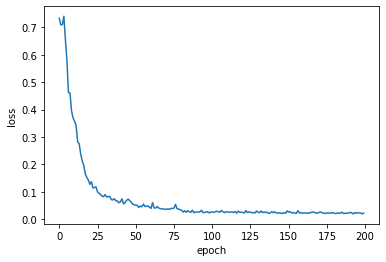

In [31]:
plt.plot(loss_)
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'dice coefficient')

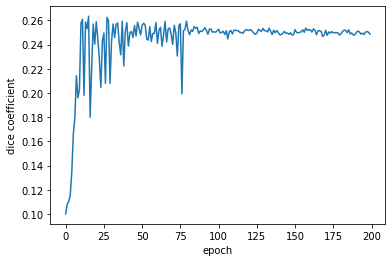

In [32]:
plt.plot(acc_)
plt.xlabel('epoch')
plt.ylabel('dice coefficient')

In [14]:
model_path = '/home/zhangj41/HW/group_proj/Organ_nuclei_models/unet_epoch185.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

28
torch.Size([100, 3, 128, 128]) torch.Size([100, 1, 128, 128]) torch.Size([100, 1, 128, 128])


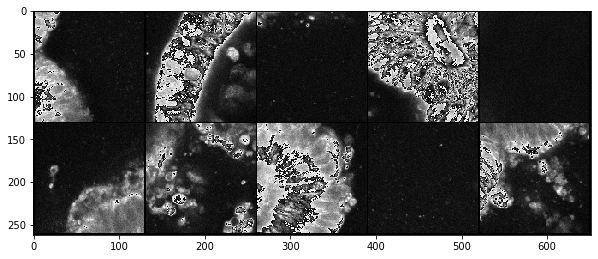

In [15]:
batch_datas, batch_labels = next(iter(DATALOADER_TEST)) 
batch_labels.unsqueeze_(1)

print(len(DATALOADER_TRAIN))
plt.figure(figsize=(10,5))
img = make_grid(batch_datas[0:10], nrow=5, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


batch_datas, batch_labels = batch_datas.cuda(), batch_labels.cuda()

pred_masks = model(batch_datas)
print(batch_datas.size(), batch_labels.size(), pred_masks.size())

torch.Size([3, 128, 128])


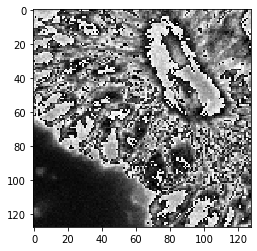

In [16]:
batch_data = batch_datas[3]
print(batch_data.size())
batch_data = batch_data.cpu().data.numpy()
plt.imshow(np.transpose(batch_data, (1,2,0)), cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


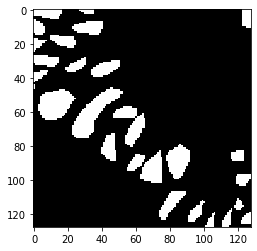

In [17]:
batch_label = batch_labels[3]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

torch.Size([128, 128])


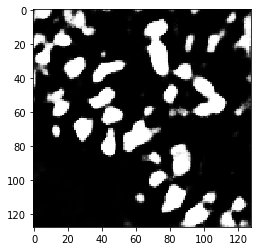

In [18]:
pred_mask = pred_masks[3]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

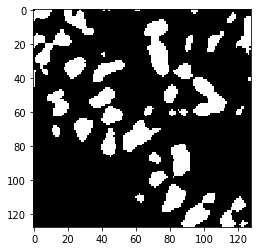

In [19]:
pred_mask[pred_mask>0.5] = 1
pred_mask[pred_mask<=0.5] = 0
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

In [ ]:
batch_label = batch_labels[8]
batch_label.squeeze_()
print(batch_label.size())
batch_label = batch_label.cpu().data.numpy()
plt.imshow(batch_label, cmap='gray', vmin=0, vmax=1)

In [ ]:
pred_mask = pred_masks[8]
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

## Metrics

In [23]:
model_path = '/home/zhangj41/HW/group_proj/Organ_nuclei_models/unet_epoch185.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

solver = CellSeg(unet=model)
iou_avg, precision_avg, dice_coeff_avg = solver.eval_epoch(dataloader=DATALOADER_TEST)

Normal IOU of the dataset: 0.252280
Normal PREC of the dataset: 0.215774
Normal DICE SCORE of the dataset: 0.995230


## Whole image

In [72]:
def img_preprocess(img_dir):
    image = imageio.imread(img_dir).astype("uint8")
    hist, bins = np.histogram(image, bins=256, range=[0,256])
    cum_hist = np.cumsum(hist)
    height, width = image.shape
    norm_cum_hist = cum_hist / (height * width)
    hists_cdf = (norm_cum_hist * 255).astype("uint8")
    # mapping
    img_eq = hists_cdf[image]
    return image
#     plt.imshow(img_eq, cmap='gray', vmin=0, vmax=255)
#     return img_eq

img_transform= transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])

In [73]:
model_path = '/home/zhangj41/HW/group_proj/Organ_nuclei_models/unet_epoch185.pth'
model = UNet(num_kernel=32, kernel_size=3, dim=3, target_dim=1)
model = model.cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

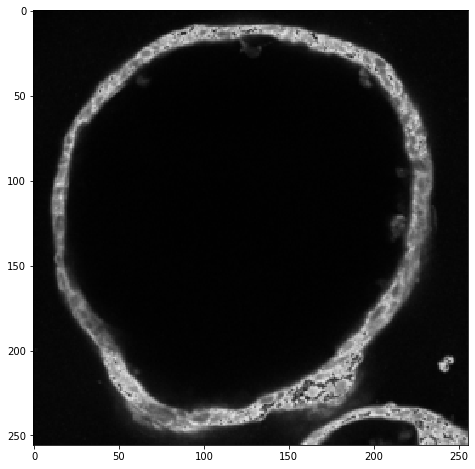

In [78]:
### read the whole image and convert to torch.Tensor
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.tiff'
image_save = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/S1_B6.FCAKPK_Control 1n_photons.png'
cell_img = img_preprocess(img_dir=image_loc)
cell_img = Image.fromarray(cell_img)
cell_img.save(image_save)

imgs = Image.open(image_save).convert('RGB')
imgs = img_transform(imgs)

npimg = imgs.numpy()
plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

torch.Size([256, 256])


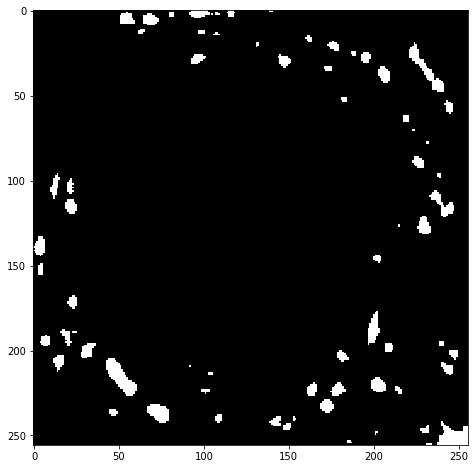

In [79]:
imgs.unsqueeze_(0)
imgs = imgs.cuda()
# imgs.size()

pred_mask = model(imgs)
pred_mask.squeeze_()
print(pred_mask.size())
pred_mask = pred_mask.cpu().data.numpy()
pred_mask[pred_mask>=0.80] = 1
pred_mask[pred_mask<0.80] = 0

plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray', vmin=0, vmax=1)

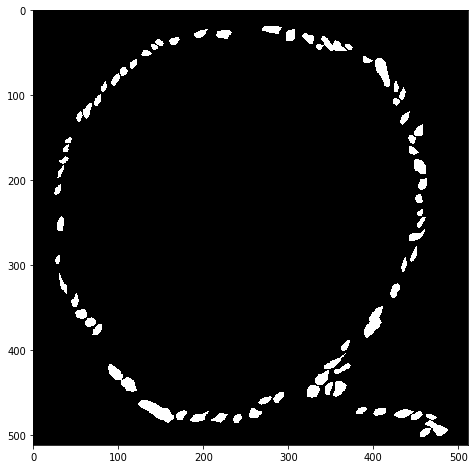

In [80]:
image_loc = '/home/zhangj41/HW/group_proj/Organoids_3D/191120_B6.FCAKPK_Folfox/S1_B6.FCAKPK_Control/Masks/Nuclei_mask_01.tiff'
image = imageio.imread(image_loc).astype("uint8")

image[image>0.5] = 1
image[image<=0.5] = 0

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=0, vmax=1)